In [3]:
# Importaciones necesarias
import zipfile
from pathlib import Path
import shutil
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Lambda 
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  
import warnings
warnings.simplefilter('ignore', category=UserWarning)

AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

Quise descomprimir un zip de imagenes, y guardarlas en carpetas para el modelo, y comprobe que siya estaba extraido o hubiera ya contenido no hacia falta que volviese a descomprimir.

In [164]:
# Rutas
zip_path = Path("dogs-vs-cats/train.zip")
extract_to_dog = Path("data_sample/train/dogs")
extract_to_cat = Path("data_sample/train/cats")

# Crear carpetas destino si no existen
extract_to_dog.mkdir(parents=True, exist_ok=True)
extract_to_cat.mkdir(parents=True, exist_ok=True)

# Comprobar si ya hay imágenes procesadas
if not any(extract_to_dog.iterdir()) or not any(extract_to_cat.iterdir()):
    print("🔄 Procesando imágenes desde el ZIP...")

    # Contadores y límites
    dog_count = 0
    cat_count = 0
    max_images = 12500

    # Extraer y procesar imágenes del ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in sorted(zip_ref.namelist()):
            if file.startswith("train/dog.") and file.endswith(".jpg") and dog_count < max_images:
                zip_ref.extract(file, "temp_extract")
                extracted_path = Path("temp_extract") / file
                output_path = extract_to_dog / Path(file).name

                with Image.open(extracted_path) as img:
                    resized_img = img.resize((200, 200))
                    resized_img.save(output_path)

                dog_count += 1

            elif file.startswith("train/cat.") and file.endswith(".jpg") and cat_count < max_images:
                zip_ref.extract(file, "temp_extract")
                extracted_path = Path("temp_extract") / file
                output_path = extract_to_cat / Path(file).name

                with Image.open(extracted_path) as img:
                    resized_img = img.resize((200, 200))
                    resized_img.save(output_path)

                cat_count += 1

            if dog_count >= max_images and cat_count >= max_images:
                break

    # Limpiar temporales
    shutil.rmtree("temp_extract", ignore_errors=True)

    print(f"✅ {dog_count} imágenes de perros procesadas en: {extract_to_dog}")
    print(f"✅ {cat_count} imágenes de gatos procesadas en: {extract_to_cat}")
else:
    print("✅ Las carpetas ya contienen imágenes procesadas. No se extrae ni redimensiona el zip.")


✅ Las carpetas ya contienen imágenes procesadas. No se extrae ni redimensiona el zip.


In [165]:
# Cargar imágenes de gatos para convertirlas en tensores
cats_subfolder = "data_sample/train/cats"
cats_image_files = sorted(os.listdir(cats_subfolder))

# Convertir imágenes a tensores normalizados
cat_tensors = []

for i in range(min(9, len(cats_image_files))):  # Limitar a máximo 9 imágenes
    img_path = os.path.join(cats_subfolder, cats_image_files[i])
    img = image.load_img(img_path, target_size=(200, 200))  # asegurarse del tamaño
    img_array = image.img_to_array(img) / 255.0  # normalizar
    cat_tensors.append(img_array)

cat_tensors = np.array(cat_tensors)
print(f"Forma del tensor: {cat_tensors.shape}")  # (9, 200, 200, 3)

Forma del tensor: (9, 200, 200, 3)


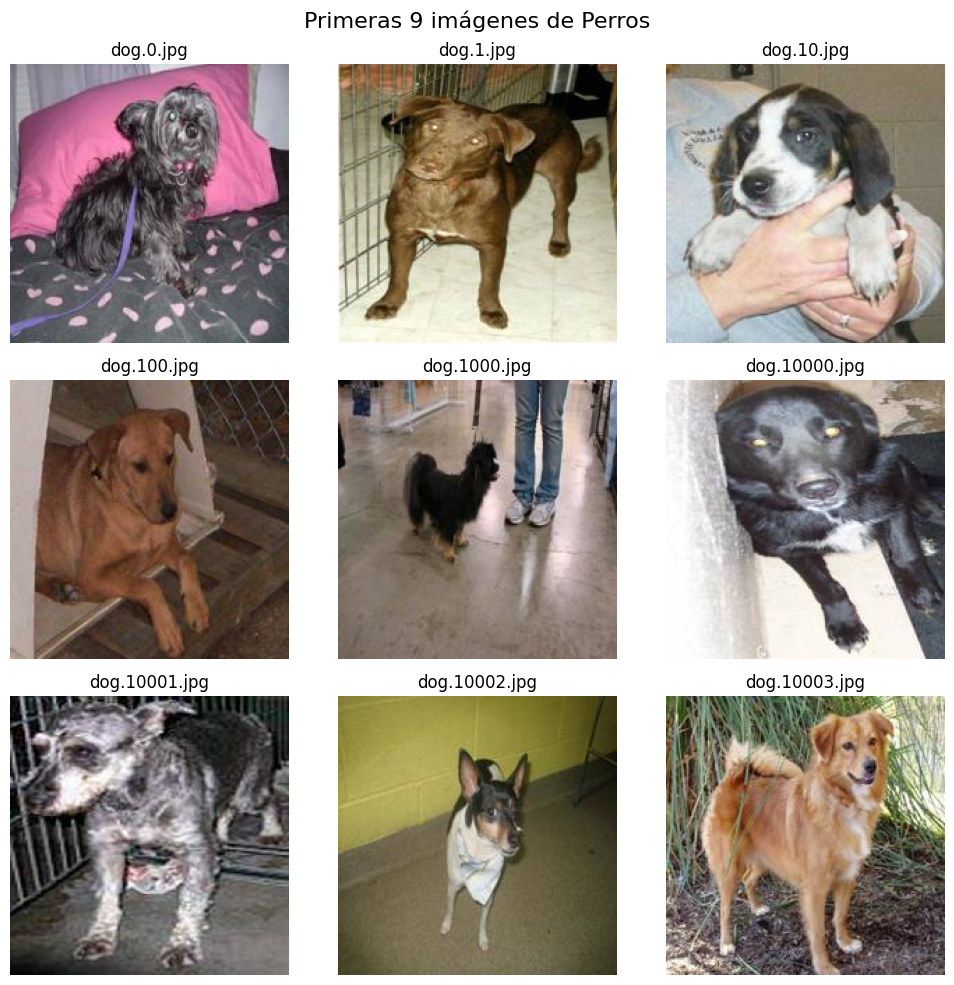

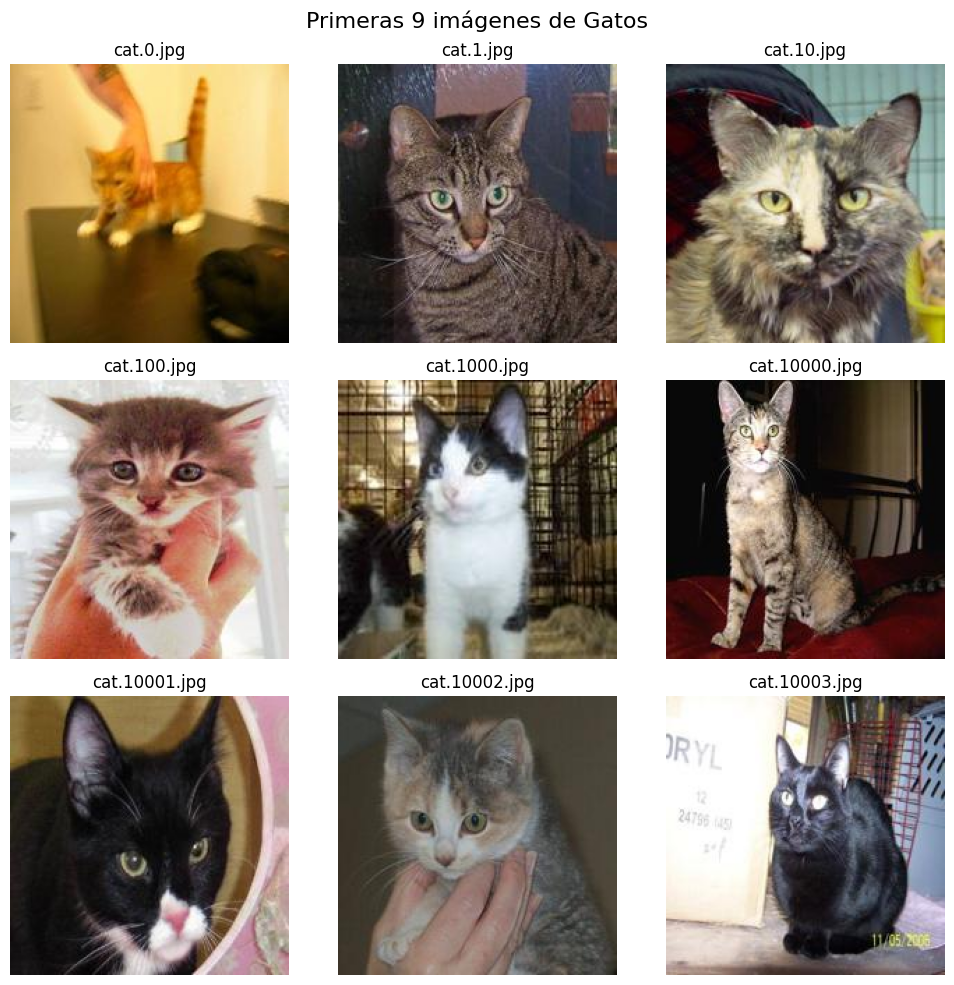

In [166]:
# Función para mostrar imágenes
image_size = (200, 200)

def show_images(image_dir, title, num_images=9):
    image_paths = sorted(Path(image_dir).glob("*.jpg"))[:num_images]
    
    image_array = []
    # Cargar las imágenes y normalizarlas
    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=image_size)  # Cambia el tamaño si es necesario
        img_array = image.img_to_array(img)  # Convierte a array
        img_array /= 255.0  # Normaliza los valores de píxeles a [0, 1]
        image_array.append(img_array)

    # Mostrar las imágenes
    plt.figure(figsize=(10, 10))
    for i, img_array in enumerate(image_array):
        plt.subplot(3, 3, i + 1)  # Crear una grilla de 3x3
        plt.imshow(img_array)
        plt.title(image_paths[i].name)  # Muestra el nombre del archivo de la imagen
        plt.axis("off")  # Desactiva los ejes
    plt.suptitle(title, fontsize=16)  # Título general
    plt.tight_layout()
    plt.show()

# Mostrar primeros 9 perros
show_images("data_sample/train/dogs", "Primeras 9 imágenes de Perros")

# Mostrar primeros 9 gatos
show_images("data_sample/train/cats", "Primeras 9 imágenes de Gatos")


Carga datos desde carpetas estructuradas por clase.

Divide automáticamente los datos en entrenamiento y validación.

Convierte las imágenes a escala de grises, redimensiona y normaliza.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir parámetros
image_size = (200,200)  # Tamaño de las imágenes
batch_size = 32  # Tamaño del lote
train_dir = "data_sample/train"  # Ruta de las imágenes de entrenamiento

# Inicializar ImageDataGenerator con Data Augmentation**
datagen = ImageDataGenerator(
    rescale=1./255,                 # Escala los píxeles de 0–255 a 0–1
    rotation_range=40,             # Rotaciones aleatorias de hasta 40°
    width_shift_range=0.2,         # Desplazamiento horizontal aleatorio (20% del ancho)
    height_shift_range=0.2,        # Desplazamiento vertical aleatorio (20% de la altura)
    shear_range=0.2,               # Transformación de corte aleatoria
    zoom_range=0.2,                # Zoom aleatorio
    horizontal_flip=True,          # Volteo horizontal aleatorio
    fill_mode='nearest',           # Relleno de pixeles vacíos tras transformaciones
    brightness_range=[0.8, 1.2],   # Variación de brillo entre 80% y 120%
    validation_split=0.2           # 80% para entrenamiento, 20% para validación
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',        # Asume solo 2 clases
    color_mode='grayscale',     # Convierte imágenes a escala de grises
    subset='training'           # Toma el 80% de los datos
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'         # Toma el 20% restante
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Cuanto cuántas imágenes hay por clase en los conjuntos de entrenamiento y validación 

In [168]:
from collections import Counter

# Contar imágenes en el set de entrenamiento
train_counts = Counter(train_data.classes)
print("\n🔢 Conteo en conjunto de entrenamiento:")
for class_label, index in train_data.class_indices.items():
    print(f"{class_label}: {train_counts[index]} imágenes")

# Contar imágenes en el set de validación
val_counts = Counter(val_data.classes)
print("\n🔢 Conteo en conjunto de validación:")
for class_label, index in val_data.class_indices.items():
    print(f"{class_label}: {val_counts[index]} imágenes")


🔢 Conteo en conjunto de entrenamiento:
cats: 10000 imágenes
dogs: 10000 imágenes

🔢 Conteo en conjunto de validación:
cats: 2500 imágenes
dogs: 2500 imágenes


Empiezo a entrenar mi modelo aplicando varias produndidad de entrenamiendo como 5 capas

In [169]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

Empiezo a entrenar mi modelo y muestros unas graficos para verlo mas visual.

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5979 - loss: 0.9338
Epoch 1: val_accuracy improved from -inf to 0.66320, saving model to models/grayscale_cnn_improved.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 1444s 2s/step - accuracy: 0.5979 - loss: 0.9334 - val_accuracy: 0.6632 - val_loss: 0.6220
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6733 - loss: 0.6052
Epoch 2: val_accuracy improved from 0.66320 to 0.70520, saving model to models/grayscale_cnn_improved.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 1492s 2s/step - accuracy: 0.6733 - loss: 0.6052 - val_accuracy: 0.7052 - val_loss: 0.5689
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6921 - loss: 0.5748
Epoch 3: val_accuracy did not improve from 0.70520
625/625 ━━━━━━━━━━━━━━━━━━━━ 1196s 2s/step - accuracy: 0.6921 - loss: 0.5748 - val_accuracy: 0.6754 - val_loss: 0.6042
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7261 - loss: 0.5449
Epoch 4: val_accuracy improved from 0.70520 to 0.74900, saving model to models/grayscale_cnn_improved.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 1183s 2s/step - accuracy: 0.7262 - loss: 0.5449 - val_accuracy: 0.7490 - val_loss: 0.5183
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7398 - loss: 0.5341
Epoch 5: val_accuracy did not improve from 0.74900
625/625 ━━━━━━━━━━━━━━━━━━━━ 1112s 2s/step - accuracy: 0.7399 - loss: 0.5341 - val_accuracy: 0.7238 - val_loss: 0.5625
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7606 - loss: 0.4934
Epoch 6: val_accuracy did not improve from 0.74900
625/625 ━━━━━━━━━━━━━━━━━━━━ 1157s 2s/step - accuracy: 0.7606 - loss: 0.4934 - val_accuracy: 0.7150 - val_loss: 0.5724
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7824 - loss: 0.4622
Epoch 7: val_accuracy improved from 0.74900 to 0.80100, saving model to models/grayscale_cnn_improved.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 1190s 2s/step - accuracy: 0.7824 - loss: 0.4622 - val_accuracy: 0.8010 - val_loss: 0.4308
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8068 - loss: 0.4285
Epoch 8: val_accuracy did not improve from 0.80100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.8068 - loss: 0.4285 - val_accuracy: 0.8002 - val_loss: 0.4350
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8263 - loss: 0.3906
Epoch 9: val_accuracy improved from 0.80100 to 0.82240, saving model to models/grayscale_cnn_improved.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 1207s 2s/step - accuracy: 0.8263 - loss: 0.3906 - val_accuracy: 0.8224 - val_loss: 0.3925
Epoch 10/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8489 - loss: 0.3485
Epoch 10: val_accuracy improved from 0.82240 to 0.83760, saving model to models/grayscale_cnn_improved.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 1065s 2s/step - accuracy: 0.8489 - loss: 0.3485 - val_accuracy: 0.8376 - val_loss: 0.3752
Epoch 11/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8560 - loss: 0.3387
Epoch 11: val_accuracy improved from 0.83760 to 0.85400, saving model to models/grayscale_cnn_improved.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 968s 2s/step - accuracy: 0.8560 - loss: 0.3387 - val_accuracy: 0.8540 - val_loss: 0.3532
Epoch 12/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8603 - loss: 0.3136
Epoch 12: val_accuracy improved from 0.85400 to 0.86760, saving model to models/grayscale_cnn_improved.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 974s 2s/step - accuracy: 0.8603 - loss: 0.3136 - val_accuracy: 0.8676 - val_loss: 0.3121
Epoch 13/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8705 - loss: 0.3015
Epoch 13: val_accuracy did not improve from 0.86760
625/625 ━━━━━━━━━━━━━━━━━━━━ 993s 2s/step - accuracy: 0.8705 - loss: 0.3015 - val_accuracy: 0.8668 - val_loss: 0.3165
Epoch 14/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8738 - loss: 0.2952
Epoch 14: val_accuracy did not improve from 0.86760
625/625 ━━━━━━━━━━━━━━━━━━━━ 983s 2s/step - accuracy: 0.8738 - loss: 0.2952 - val_accuracy: 0.8182 - val_loss: 0.4533
Epoch 15/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8819 - loss: 0.2690
Epoch 15: val_accuracy did not improve from 0.86760
625/625 ━━━━━━━━━━━━━━━━━━━━ 978s 2s/step - accuracy: 0.8819 - loss: 0.2690 - val_accuracy: 0.8672 - val_loss: 0.3227
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 12.


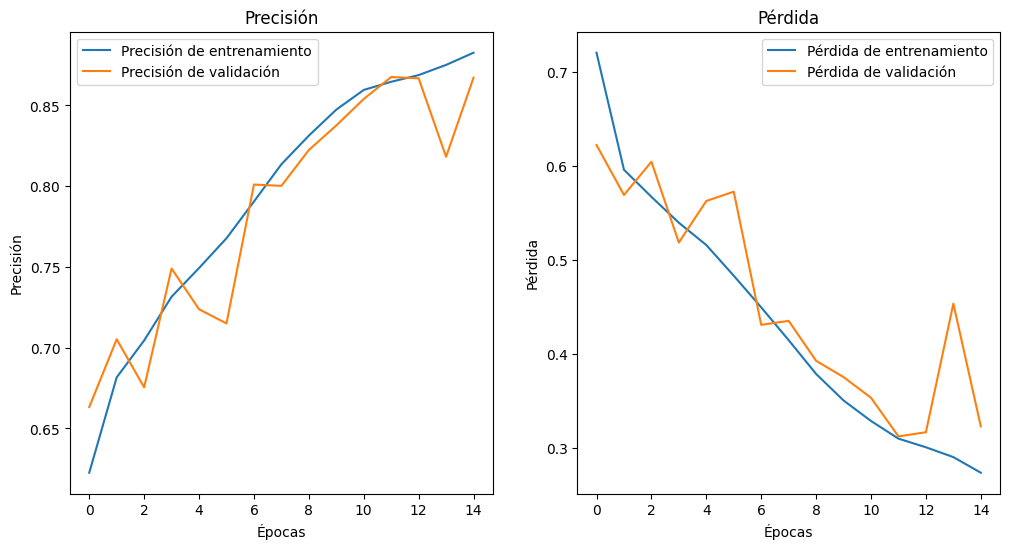

In [170]:
# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Resumen del modelo
#model.summary()

# Definir los callbacks
checkpoint = ModelCheckpoint(
    "models/grayscale_cnn_improved.h5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="max"  # Porque queremos maximizar la precisión
)

early = EarlyStopping(
    monitor="val_accuracy",
    patience=3,  # Espera 3 épocas sin mejora
    restore_best_weights=True,
    verbose=1,
    mode="max"
)

# Entrenar el modelo con los callbacks
history = model.fit(
    train_data,
    epochs=30,  # Usa más épocas
    validation_data=val_data,
    callbacks=[checkpoint, early],
    verbose=1
)
# Graficar el rendimiento
plt.figure(figsize=(12, 6))

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [171]:
print(train_data.class_indices)

{'cats': 0, 'dogs': 1}


## Por cuanto mas cerca esta de 0 menos del 50%, cree que es un gato, y si supera el 50 cree que será un perro.

Realizando varias pruebas, me acierta de cada 10,en la mayoria de las pruebas acierta 8 muchas veces, a veces 9 y 10, y muy pocas veces 7.
Hay un acierto de mas de un 70% de precision.

Tengo varios modelos que con un 50% casi siempre no ha mejorado.

<Figure size 2000x1000 with 0 Axes>

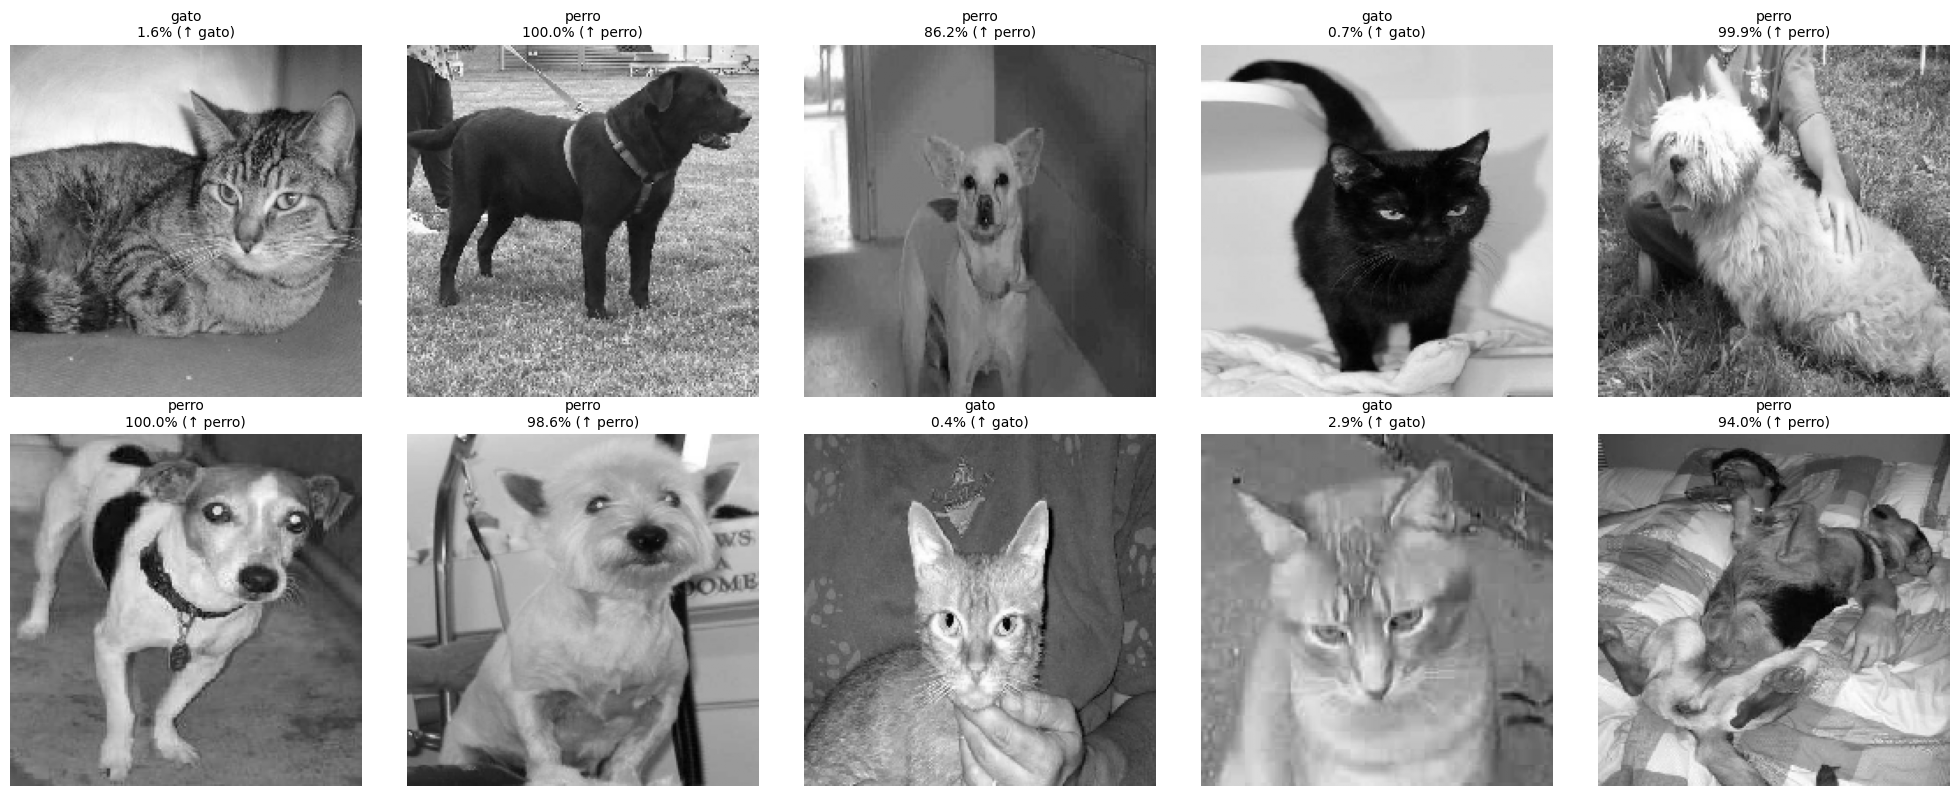

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
import random

# Diccionario para salida personalizada
sub = {0: "gato", 1: "perro"}

# Cargar el modelo una vez (fuera de la función si lo usarás repetidamente)
model = load_model("models/Mod-deep-learning/grayscale_cnn_improved.h5")

IMAGE_DIR = "data/raw/test"

#model.summary()
plt.figure(figsize=(20,10))  # Ajusta el tamaño si tienes más imágenes

def predict_images(num_images=10):
    # Obtener todos los archivos .jpg en la carpeta
    all_images = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg")]
    
    # Seleccionar aleatoriamente 10 imágenes
    selected_images = random.sample(all_images, num_images)

    rows, cols = 2, num_images // 2
    plt.figure(figsize=(cols * 4, rows * 4))  # Ajusta el tamaño total del gráfico

    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(IMAGE_DIR, img_name)

        # Cargar imagen
        img = image.load_img(img_path, target_size=(200, 200), color_mode="grayscale")
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Predecir
        prediction = model.predict(img_array, verbose=0)[0][0]
        binary_label = int(prediction > 0.5)

        # Determinar a qué clase tiende
        clase_tendencia = "perro" if prediction > 0.5 else "gato"
        porcentaje = prediction * 100

        # Mostrar imagen
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_array[0].squeeze(), cmap="gray")
        plt.title(f"{sub[binary_label]}\n{porcentaje:.1f}% (↑ {clase_tendencia})", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


predict_images()

